# Mask R-CNN - Inspect Newspaper Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("/Users/OverPass17/Desktop/Mask-RCNN-TF2-3.0/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.newspapers import newspapers

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [23]:
# Path to NEWSPAPER trained weights
NEWSPAPER_WEIGHTS_PATH = os.path.abspath("/Users/OverPass17/Desktop/Mask-RCNN-TF2-3.0/mask_rcnn_newspapers_0030.h5") 

In [24]:
MODEL_DIR

'/Users/OverPass17/Desktop/Mask-RCNN-TF2-3.0/logs'

In [25]:
NEWSPAPER_WEIGHTS_PATH

'/Users/OverPass17/Desktop/Mask-RCNN-TF2-3.0/mask_rcnn_newspapers_0030.h5'

## Configurations

In [26]:
config = newspapers.NewspaperConfig()
NEWSPAPER_DIR = os.path.abspath("/Users/OverPass17/Desktop/Mask-RCNN-TF2-3.0/FSL/") #ABSOLUTE PATH

In [27]:
NEWSPAPER_DIR

'/Users/OverPass17/Desktop/Mask-RCNN-TF2-3.0/FSL'

In [28]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.003
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [29]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [30]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [31]:
# Load validation dataset
dataset = newspapers.NewspaperDataset()
dataset.load_newspaper(NEWSPAPER_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 53
Classes: ['BG', 'people']


## Load Model

In [32]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [34]:
# Set path to Newspaper weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = NEWSPAPER_WEIGHTS_PATH

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /Users/OverPass17/Desktop/Mask-RCNN-TF2-3.0/mask_rcnn_newspapers_0030.h5


## Run Detection

image ID: newspaper.7362__11_240__6.jpg (8) /Users/OverPass17/Desktop/Mask-RCNN-TF2-3.0/FSL/train/7362__11_240__6.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  204.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  100.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  262.00000  max:  483.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
image ID: newspaper.7535__3_316_.jpg (39) /Users/OverPass17/Desktop/Mask-RCNN-TF2-3.0/FSL/train/7535__3_316_.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.0000

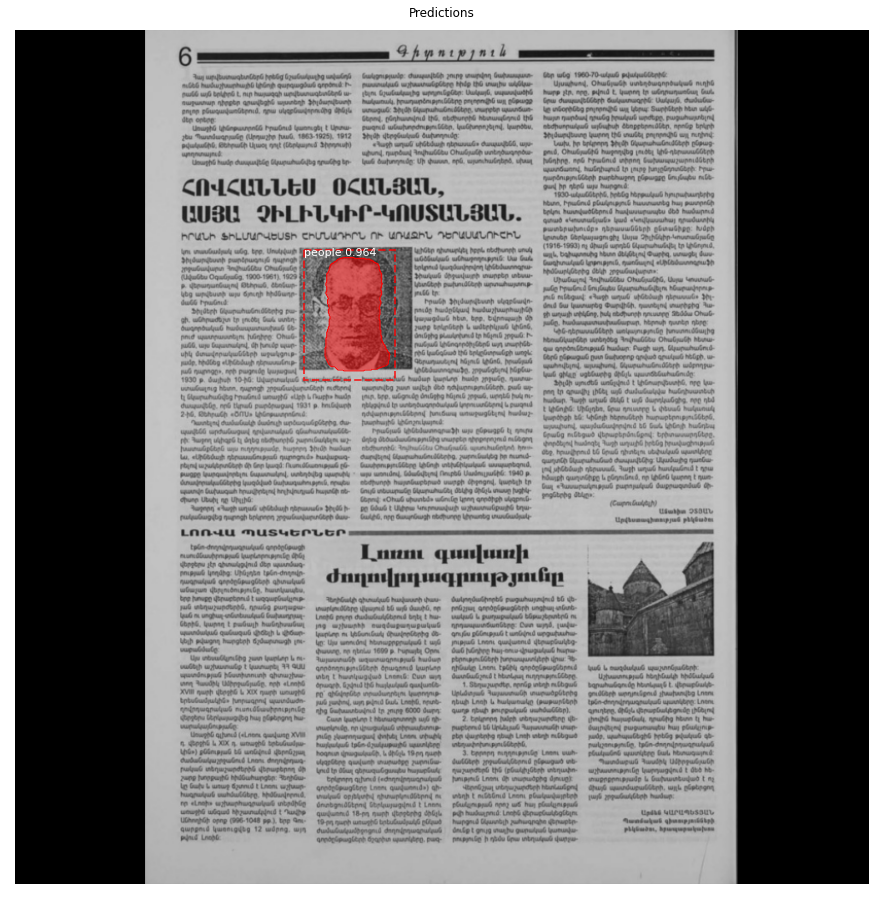

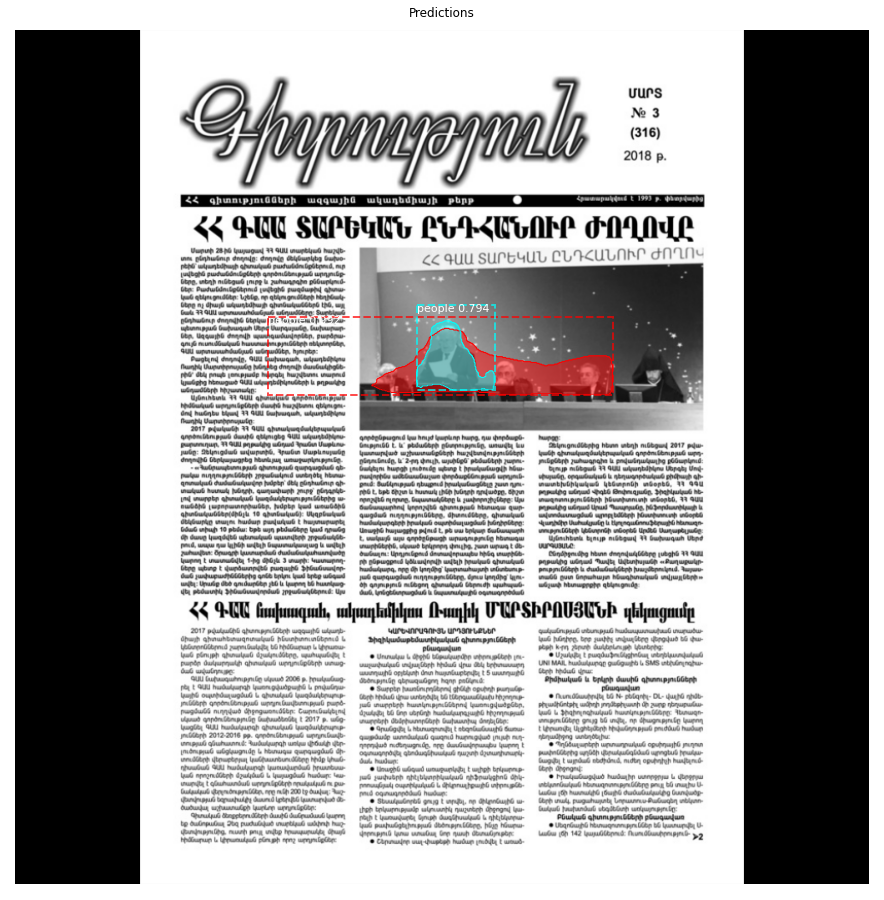

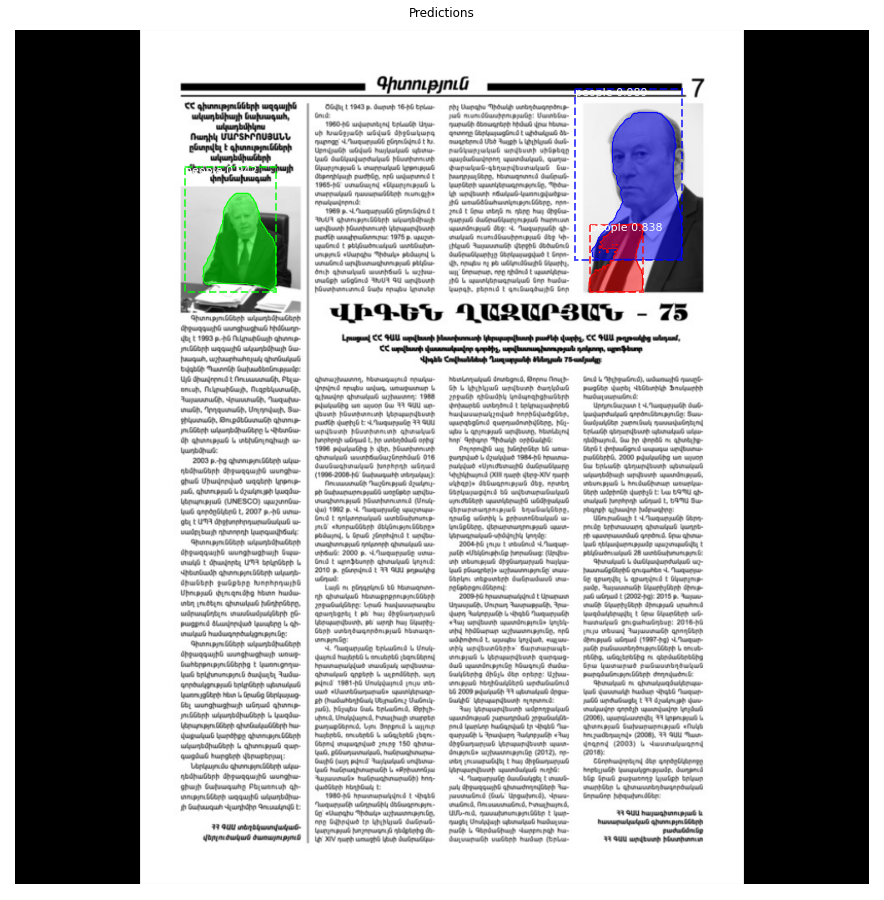

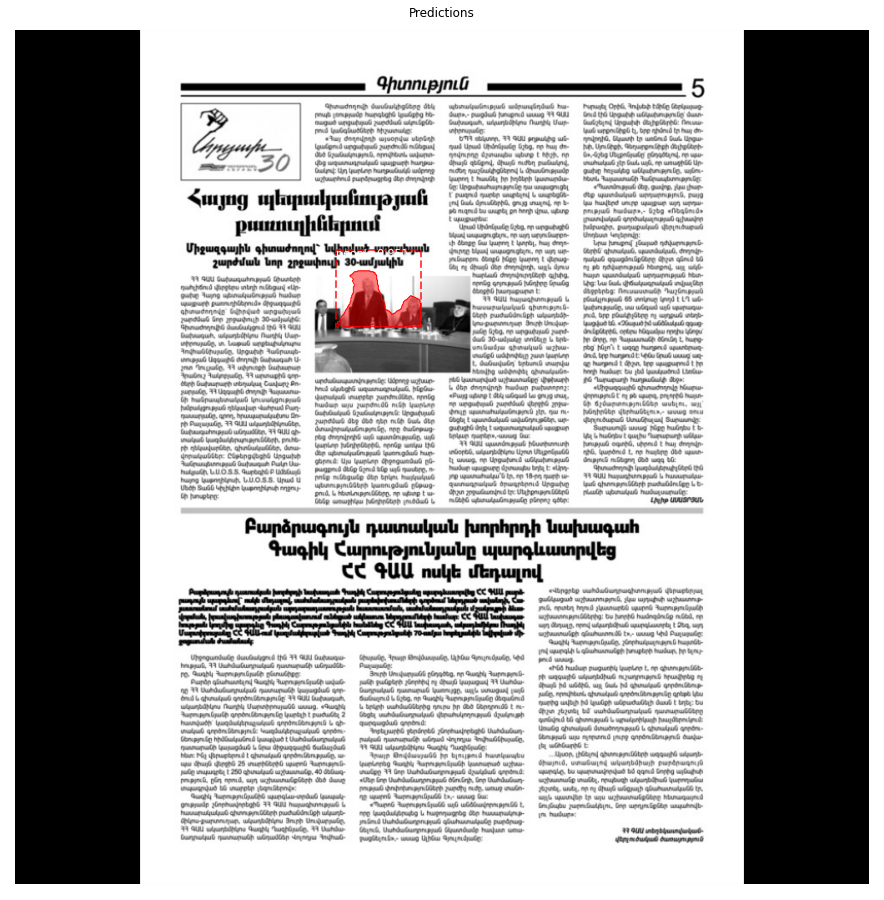

In [35]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           dataset.image_reference(image_id)))

    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    ax = get_ax(1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=ax,
                                title="Predictions")
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)